In [1]:
# ! pip install mapclassify
# ! pip install fiona
# ! pip install shapely descartes geopandas

from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
import fiona
import geopandas as gdp

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

## About


Biddeford, Maine, just went through a contentious mayoral campaign where the big issue centered around adding a giant parking lot in the heart of the downtown and whether it was a smart idea to continue being so development focus in that one spot. The incumbent heavily favored the continued development push while the challenger gained his legitimacy to run via earlier challenges to the parking lot development pushes. The incumbent won by a little over 200 votes so this garage will likely be built but the opposing side never ran the analytics on other scenarios.

**add tweets from candidates?**

### Biddeford, Maine

<img src="../images/map-biddeford-maine-satellite.jpg" />




## Research Question
This begs the question: are there other possible options to increase overall valuation of the city in a similar fashion? 


## The Big Picture
Biddeford, Maine is a "city" of a little over 20,000 year long residents. Whether a parking gararge is developed or not likely will not have far reaching consequences. What can though is showing others that it is possible for reqular citizens to critically analyaze their municipality's fiannces in a sophisitcated fashion.


## Criteria 
City Hall already created a presentation with predicitions on the value that the garage will produce for the city which means there's a rough benchmark to grade ideas against. `$16,407,604` in property taxes in the first 10 years of operation and a benefit of `$39,772,744` over the 25 year lifetime of the agreement: https://www.biddefordmaine.org/2913/Downtown-Parking-Garage-Project-Informat.

To keep things simple and focused on other possible growth solutions instead of analysing the results posted on the city's website we are going to avoid doing typical financial analysis like net projected value calculations, discounting future dollars and accounting for inflation. 


## Data
We will be valuing everything in late 2019/ early 2020 dollars so will use financial year 2020, which ends June 2020, stats as a base for all analysis.


**need to update how data was obtained**
Biddeford does not have their propery assessment data available in a `SQL`,`CSV`, or any other other file types readily available to download that was used in class but they do provide a detail database in `dbf` formatting and `shapefile`s with much of the `dbf` data joined with it. All of this data can be found in the GIS section of the city's website: https://www.biddefordmaine.org/2522/GIS-Data-Catalog

There is also a seperate DBF file with just property related info called `Vision Parcel Data.` Doing a clean convert to CSV for this and the other joined databased is not smooth because of poorly formated records tracking previous owner(s) data. Luckily this study is agnostic to owner related data and not looking to anylyse sale data.

The joined data ended up being used because it produces less wrong results when comparing publicaly stated total property tax revenues less all other publicaly stated considerations. Someone who knows public finance likely can spot the error. It was also better formatted and needed little cleaning besides removing columns (variables) tracking personal identification and political district info for local, state and federal.

There are two officail versions of the dataset that came with the GIS and Parcels data joined - `.dbf` and a `.shp` file. The `.dbf` was marginally cleaned via dropping personal id and political districting info. The rest of the data set was not editted minus minor column name edits for the `CSV` file version.

Again, this exercise to think of other viable total property growth strategies for the city

## Steps
- Download Data
- Understand and Clean Data
- Verify Assumptions
- Visualize and Ananlyze Data
- Suggest Proposals
- Conclusions

### Download Data

In [2]:
# cleaned property value data - not being used
nonjoined_biddeford_tax = r'vision-2018-2019.csv'
basictaxdata = pd.read_csv(nonjoined_biddeford_tax, sep=',')

# uncleaned parcel data - meant to be inner joined w/ basictaxdata
# to see if this elimanates what seems to be sporidic junk data in 
# joined data set given by muni
# did: tax_parcels_joined = gdp.concat([basictaxdata, parcels], axis=1, join='inner')
# but it broke geo heat maps of property values
nonjoin_parcels = 'Parcels/Parcels.shp'
parcels = gdp.read_file(nonjoin_parcels)
#tax_columns = basictaxdata.columns
#parcels_columns = parcels.columns
#parcels.describe().transpose()
# basictaxdata['Bed_Cnt']
#tax_columns
# parcels['LinkID'].unique().shape
# (7594,)
# basictaxdata['GISID'].unique().shape
# 7611,
## parcels.shape looks like LinkID and GISID are keys for the two databases
# tax_parcels_joined.head(30)
# biddeford_parcels = tax_parcels_joined
# taxdata = tax_parcels_joined

# used for heat maps
joined_vision_parcels = 'Parcels/Parcels_Vision_Join.shp'
biddeford_parcels = gdp.read_file(joined_vision_parcels)

# This will be used for all other analysis
cleaned_csv_copy = r'parcels-joined-cleaned.csv'
taxdata = pd.read_csv(cleaned_csv_copy, sep=',')

### Understand and Clean Data

Taking a moment to explore and clean your data set allows one to gain some understanding of what possible methods one can take in tackling the project and make your dataset eaiser to use. Things to check while doing this are:

- printing the dataset
- checking shape
- listing columns
- checking descreptive stats
- summation of columns

In [3]:
taxdata

,Map,Lot,SubLot,Polytype,LinkID,TM_update_,Hist_Dist,Pine_Tr_Zn,OL_CAC,Lot_Sub,...,Sale_Date,Year_Built,Land_Area,Build_Styl,Bath_Cnt,Exempt_Val,Bed_Cnt,Tax_Total,LU_CODE,LU_DESC4
0,0,0,0,parcel,NaN,0,0,0,0,NaN,...,NaN,0,0,NaN,NaN,0,NaN,0,NaN,NaN
1,0,0,0,parcel,NaN,0,0,0,0,NaN,...,NaN,0,0,NaN,NaN,0,NaN,0,NaN,NaN
2,0,0,0,parcel,NaN,0,0,0,1,NaN,...,NaN,0,0,NaN,NaN,0,NaN,0,NaN,NaN
3,0,0,0,parcel,NaN,0,0,0,1,NaN,...,NaN,0,0,NaN,NaN,0,NaN,0,NaN,NaN
4,0,0,0,parcel,NaN,0,0,0,1,NaN,...,NaN,0,0,NaN,NaN,0,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8027,9,9,1,parcel,9-9-1,0,0,0,1,9-1,...,04/11/99,1993,139392,Ranch,1.0,20000,2.0,269600,1010,SINGLE FAM MDL-01
8028,9,9,2,parcel,9-9-2,0,0,0,1,9-2,...,08/19/91,1992,43996,Cape,1.5,20000,3.0,228500,1010,SINGLE FAM MDL-01
8029,9,9,3,parcel,9-9-3,0,0,0,1,9-3,...,12/18/12,2000,195584,Cape,2.0,0,2.0,243700,1010,SINGLE FAM MDL-01
8030,9,9,4,parcel,9-9-4,0,0,0,1,9-4,...,10/31/08,2001,101059,Ranch,1.5,20000,3.0,247500,1010,SINGLE FAM MDL-01


In [4]:
taxdata.transpose()

,0,1,2,3,4,5,6,7,8,9,...,8022,8023,8024,8025,8026,8027,8028,8029,8030,8031
Map,0,0,0,0,0,0,33,10,10,10,...,9,9,9,9,9,9,9,9,9,9
Lot,0,0,0,0,0,0,0,1,10,10,...,8,8,8,8,9,9,9,9,9,9
SubLot,0,0,0,0,0,0,0,0,0,1,...,4,5,6,7,0,1,2,3,4,5
Polytype,parcel,parcel,parcel,parcel,parcel,parcel,ROW,parcel,parcel,parcel,...,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel
LinkID,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10-1,10-10,10-10-1,...,9-8-4,9-8-5,9-8-6,9-8-7,9-9,9-9-1,9-9-2,9-9-3,9-9-4,9-9-5
TM_update_,0,0,0,0,0,0,0,0,2012,2012,...,0,0,0,2014,0,0,0,0,0,0
Hist_Dist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pine_Tr_Zn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
OL_CAC,0,0,1,1,1,0,0,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Lot_Sub,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,10,10-1,...,8-4,8-5,8-6,8-7,9,9-1,9-2,9-3,9-4,9-5


Looks like there's some junk data in this set. Going to `dropna` all records with the `Location` variable set to `NaN`

In [5]:
cleanedtax = taxdata.dropna(subset=['Location'])

In [6]:
cleanedtax

,Map,Lot,SubLot,Polytype,LinkID,TM_update_,Hist_Dist,Pine_Tr_Zn,OL_CAC,Lot_Sub,...,Sale_Date,Year_Built,Land_Area,Build_Styl,Bath_Cnt,Exempt_Val,Bed_Cnt,Tax_Total,LU_CODE,LU_DESC4
7,10,1,0,parcel,10-1,0,0,0,1,1,...,07/13/09,1915,16988,Cottage,0.5,0,3.0,331800,1012,OCN FT MDL-01
8,10,10,0,parcel,10-10,2012,0,0,1,10,...,10/27/71,0,392040,Vacant Land,NaN,0,NaN,3200,9010,STATE OWND MDL-00
9,10,10,1,parcel,10-10-1,2012,0,0,1,10-1,...,10/27/71,0,392040,Vacant Land,NaN,0,NaN,3800,1320,RES ACLNUD MDL-00
10,10,11,1,parcel,10-11-1,0,0,0,1,11-1,...,12/11/15,0,599821,Vacant Land,NaN,0,NaN,334800,9000,US GOVT MDL-00
11,10,12,0,parcel,10-12,0,0,0,1,12,...,10/26/02,1998,30492,Colonial,2.0,0,3.0,302300,1010,SINGLE FAM MDL-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8027,9,9,1,parcel,9-9-1,0,0,0,1,9-1,...,04/11/99,1993,139392,Ranch,1.0,20000,2.0,269600,1010,SINGLE FAM MDL-01
8028,9,9,2,parcel,9-9-2,0,0,0,1,9-2,...,08/19/91,1992,43996,Cape,1.5,20000,3.0,228500,1010,SINGLE FAM MDL-01
8029,9,9,3,parcel,9-9-3,0,0,0,1,9-3,...,12/18/12,2000,195584,Cape,2.0,0,2.0,243700,1010,SINGLE FAM MDL-01
8030,9,9,4,parcel,9-9-4,0,0,0,1,9-4,...,10/31/08,2001,101059,Ranch,1.5,20000,3.0,247500,1010,SINGLE FAM MDL-01


In [7]:
# There seems to be some columns that this research does not care about like owner and political district data.
# Going to pring out all columns and create a list of the columns that this research does not need so the data 
# can be systemically deleted from the dataframe.

cleanedtax.columns

Index(['Map', 'Lot', 'SubLot', 'Polytype', 'LinkID', 'TM_update_', 'Hist_Dist',
       'Pine_Tr_Zn', 'OL_CAC', 'Lot_Sub', 'Ward_2013', 'Export_Vis', 'FD',
       'X10D_ID', 'OBJECTID_1', 'Vision_PID', 'GISID', 'F10D_ID', 'Map_1',
       'Block', 'Lot_1', 'St_Num', 'Street', 'Location', 'CurOwn_Dat',
       'CurOwn_QU', 'CurOwn_VI', 'CurOwn_Sal', 'PROwn1_Dat', 'PROwn1_QU',
       'PROwn1_VI', 'PROwn1_Sal', 'PROwn2_Sal', 'PROwn3_Sal', 'PROwn4_Sal',
       'PROwn5_Sal', 'Land_Val', 'Build_Val', 'Total_Val', 'Zone', 'Room_Cnt',
       'Build_SF', 'Sale_Price', 'Sale_Date', 'Year_Built', 'Land_Area',
       'Build_Styl', 'Bath_Cnt', 'Exempt_Val', 'Bed_Cnt', 'Tax_Total',
       'LU_CODE', 'LU_DESC4'],
      dtype='object')

In [8]:
#'Map_1', 'Block', 'Lot_1' appear to duplicates to 'Map', 'Lot', 'SubLot'
# so adding a set to the delete these columns list as well

# 'OL_CAC', looks useless as well

delete_these_columns = [
'CurOwn_Dat',
'CurOwn_QU',
'CurOwn_VI',
'CurOwn_Sal',
'Sale_Price',
'Sale_Date',
'TM_update_',
'Map_1',
'Block',
'Lot_1',
'OL_CAC'
]


cleanedtax = cleanedtax.drop(delete_these_columns, axis=1)

In [9]:
cleanedtax.columns

Index(['Map', 'Lot', 'SubLot', 'Polytype', 'LinkID', 'Hist_Dist', 'Pine_Tr_Zn',
       'Lot_Sub', 'Ward_2013', 'Export_Vis', 'FD', 'X10D_ID', 'OBJECTID_1',
       'Vision_PID', 'GISID', 'F10D_ID', 'St_Num', 'Street', 'Location',
       'PROwn1_Dat', 'PROwn1_QU', 'PROwn1_VI', 'PROwn1_Sal', 'PROwn2_Sal',
       'PROwn3_Sal', 'PROwn4_Sal', 'PROwn5_Sal', 'Land_Val', 'Build_Val',
       'Total_Val', 'Zone', 'Room_Cnt', 'Build_SF', 'Year_Built', 'Land_Area',
       'Build_Styl', 'Bath_Cnt', 'Exempt_Val', 'Bed_Cnt', 'Tax_Total',
       'LU_CODE', 'LU_DESC4'],
      dtype='object')

In [10]:
# appears the .columns method does not call all columns in dataframe
# need to do more cleaning

more_column_deletes = [
'Ward_2013',
'PROwn1_Dat',
'PROwn1_QU',
'PROwn1_VI',
'PROwn1_Sal',
'PROwn2_Sal',
'PROwn3_Sal',
'PROwn4_Sal',
'PROwn5_Sal'
]


cleanedtax = cleanedtax.drop(more_column_deletes, axis=1)

In [11]:
cleanedtax = cleanedtax.drop(['Export_Vis'], axis=1)

cleanedtax

,Map,Lot,SubLot,Polytype,LinkID,Hist_Dist,Pine_Tr_Zn,Lot_Sub,FD,X10D_ID,...,Build_SF,Year_Built,Land_Area,Build_Styl,Bath_Cnt,Exempt_Val,Bed_Cnt,Tax_Total,LU_CODE,LU_DESC4
7,10,1,0,parcel,10-1,0,0,1,Bask,1010001000,...,922,1915,16988,Cottage,0.5,0,3.0,331800,1012,OCN FT MDL-01
8,10,10,0,parcel,10-10,0,0,10,Stag,1010010000,...,0,0,392040,Vacant Land,NaN,0,NaN,3200,9010,STATE OWND MDL-00
9,10,10,1,parcel,10-10-1,0,0,10-1,Stag,1010010001,...,0,0,392040,Vacant Land,NaN,0,NaN,3800,1320,RES ACLNUD MDL-00
10,10,11,1,parcel,10-11-1,0,0,11-1,3,1010011001,...,0,0,599821,Vacant Land,NaN,0,NaN,334800,9000,US GOVT MDL-00
11,10,12,0,parcel,10-12,0,0,12,3,1010012000,...,1664,1998,30492,Colonial,2.0,0,3.0,302300,1010,SINGLE FAM MDL-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8027,9,9,1,parcel,9-9-1,0,0,9-1,3,1009009001,...,1120,1993,139392,Ranch,1.0,20000,2.0,269600,1010,SINGLE FAM MDL-01
8028,9,9,2,parcel,9-9-2,0,0,9-2,3,1009009002,...,1652,1992,43996,Cape,1.5,20000,3.0,228500,1010,SINGLE FAM MDL-01
8029,9,9,3,parcel,9-9-3,0,0,9-3,3,1009009003,...,994,2000,195584,Cape,2.0,0,2.0,243700,1010,SINGLE FAM MDL-01
8030,9,9,4,parcel,9-9-4,0,0,9-4,3,1009009004,...,1498,2001,101059,Ranch,1.5,20000,3.0,247500,1010,SINGLE FAM MDL-01


#### Check Shape

This is down to understand the size of data set

In [12]:
cleanedtax.shape

(8018, 32)

#### List Columns

This checks the type of variables each sample in theory should be tracking

In [13]:
cleanedtax.columns

Index(['Map', 'Lot', 'SubLot', 'Polytype', 'LinkID', 'Hist_Dist', 'Pine_Tr_Zn',
       'Lot_Sub', 'FD', 'X10D_ID', 'OBJECTID_1', 'Vision_PID', 'GISID',
       'F10D_ID', 'St_Num', 'Street', 'Location', 'Land_Val', 'Build_Val',
       'Total_Val', 'Zone', 'Room_Cnt', 'Build_SF', 'Year_Built', 'Land_Area',
       'Build_Styl', 'Bath_Cnt', 'Exempt_Val', 'Bed_Cnt', 'Tax_Total',
       'LU_CODE', 'LU_DESC4'],
      dtype='object')

In [14]:
cleanedtax.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Map,8018.0,3.593303e+01,2.319166e+01,1.000000e+00,2.000000e+01,3.400000e+01,5.000000e+01,8.800000e+01
Lot,8018.0,7.111537e+01,8.370630e+01,1.000000e+00,1.700000e+01,3.900000e+01,8.800000e+01,4.760000e+02
SubLot,8018.0,8.509603e-01,2.475750e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01
Hist_Dist,8018.0,2.419556e-02,2.128778e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
Pine_Tr_Zn,8018.0,1.970566e-02,2.162439e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
X10D_ID,8018.0,1.036004e+09,2.318829e+07,1.001001e+09,1.020046e+09,1.034252e+09,1.050024e+09,1.088055e+09
OBJECTID_1,8018.0,4.028685e+03,2.320216e+03,1.000000e+00,2.023250e+03,4.031500e+03,6.036750e+03,8.043000e+03
Vision_PID,8018.0,1.617226e+04,3.449062e+04,8.000000e+00,2.162250e+03,4.200500e+03,6.274750e+03,1.221280e+05
F10D_ID,8018.0,1.035249e+09,3.660295e+07,0.000000e+00,1.020045e+09,1.034252e+09,1.050024e+09,1.088055e+09
St_Num,8018.0,9.540758e+01,1.489711e+02,0.000000e+00,8.000000e+00,2.500000e+01,1.100000e+02,9.240000e+02


There are records with `Land_Val`, `Build_Val`, `Total_Val`, and `Tax_Total` as zero. This confirms the need to sort and check the max and min records for these varaibles - especially for `Total_Val` and `Tax_Total`

In [15]:
cleanedtax = cleanedtax.sort_values(['Total_Val'])

cleanedtax.head(20)

,Map,Lot,SubLot,Polytype,LinkID,Hist_Dist,Pine_Tr_Zn,Lot_Sub,FD,X10D_ID,...,Build_SF,Year_Built,Land_Area,Build_Styl,Bath_Cnt,Exempt_Val,Bed_Cnt,Tax_Total,LU_CODE,LU_DESC4
1988,28,53,0,parcel,28-53,0,0,53,11,1028053000,...,0,1890,0,Condominium,NaN,0,NaN,0,995,CONDO MAIN
2666,33,15,0,parcel,33-15,0,0,15,13,1033015000,...,0,1986,0,Condominium,NaN,0,NaN,0,995,CONDO MAIN
2447,31,10,0,parcel,31-10,0,0,10,14,1031010000,...,0,2009,99317,Condominium,NaN,0,NaN,0,995,CONDO MAIN
500,17,22,0,parcel,17-22,0,0,22,18,1017022000,...,0,1986,0,Condo Office,NaN,0,NaN,0,995,CONDO MAIN
1344,2,56,1,parcel,2-56-1,0,0,56-1,18,1002056001,...,0,1984,0,Condo Office,NaN,0,NaN,0,995,CONDO MAIN
708,20,24,0,parcel,20-24,0,0,24,18,1020024000,...,0,1988,0,Condo Office,NaN,0,NaN,0,995,CONDO MAIN
2164,29,158,1,parcel,29-158-1,0,0,158-1,11,1029158001,...,0,1986,0,Condominium,NaN,0,NaN,0,995,CONDO MAIN
5665,54,40,0,parcel,54-40,0,0,40,3,1054040000,...,0,1988,0,Condominium,NaN,0,NaN,0,995,CONDO MAIN
5718,54,81,0,parcel,54-81,0,0,81,3,1054081000,...,0,1970,0,Condominium,NaN,0,NaN,0,995,CONDO MAIN
2955,34,205,0,parcel,34-205,0,0,205,14,1034205000,...,0,2001,0,Condominium,NaN,0,NaN,0,995,CONDO MAIN


These min values need to be analyzed some more. It looks like the city assigns all multi-units as a value of 0 and tracks the value of each individual unit. These 0 have the potential to skew any statistical analysis so going to dig deeper by filtering for all records for `Total_Val` = 0

In [16]:
zero_value_properties = cleanedtax[cleanedtax['Total_Val'] == 0]
zero_value_properties.shape

(29, 32)

In [17]:
zero_value_properties.transpose()

,1988,2666,2447,500,1344,708,2164,5665,5718,2955,...,2074,6023,6976,685,2367,6500,958,1091,1259,6007
Map,28,33,31,17,2,20,29,54,54,34,...,29,59,7,19,29,64,22,2,2,59
Lot,53,15,10,22,56,24,158,40,81,205,...,110,25,20,57,99,49,39,30,47,18
SubLot,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Polytype,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,...,parcel,parcel,open space,open space,parcel,parcel,parcel,parcel,ROW,parcel
LinkID,28-53,33-15,31-10,17-22,2-56-1,20-24,29-158-1,54-40,54-81,34-205,...,29-110,59-25,7-20,19-57,29-99,64-49,22-39,2-30,2-47,59-18
Hist_Dist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Pine_Tr_Zn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lot_Sub,53,15,10,22,56-1,24,158-1,40,81,205,...,110,25,20,57,99,49,39,30,47,18
FD,11,13,14,18,18,18,11,3,3,14,...,11,2,14,17,11,1,11,18,18,2
X10D_ID,1028053000,1033015000,1031010000,1017022000,1002056001,1020024000,1029158001,1054040000,1054081000,1034205000,...,1029110000,1059025000,1007020000,1019057000,1029099000,1064049000,1022039000,1002030000,1002047000,1059018000


In [18]:
zero_value_properties.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Map,29.0,3.213793e+01,2.148209e+01,2.000000e+00,1.900000e+01,2.900000e+01,5.400000e+01,8.200000e+01
Lot,29.0,6.072414e+01,4.876174e+01,1.000000e+01,2.500000e+01,4.200000e+01,8.500000e+01,2.050000e+02
SubLot,29.0,2.758621e-01,9.597824e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
Hist_Dist,29.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
Pine_Tr_Zn,29.0,1.034483e-01,5.570860e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
X10D_ID,29.0,1.032199e+09,2.148216e+07,1.002030e+09,1.019057e+09,1.029158e+09,1.054040e+09,1.082035e+09
OBJECTID_1,29.0,3.599172e+03,2.295672e+03,6.900000e+01,2.018000e+03,3.297000e+03,6.166000e+03,7.666000e+03
Vision_PID,29.0,9.553662e+04,3.786839e+04,2.703000e+03,1.077220e+05,1.077310e+05,1.080800e+05,1.214690e+05
F10D_ID,29.0,1.032199e+09,2.148216e+07,1.002030e+09,1.019057e+09,1.029158e+09,1.054040e+09,1.082035e+09
St_Num,29.0,8.889655e+01,1.194569e+02,0.000000e+00,1.000000e+00,2.800000e+01,1.100000e+02,4.090000e+02


In [19]:
zero_value_properties[zero_value_properties['Land_Area'] > 0 ].transpose()

,2447,2367
Map,31,29
Lot,10,99
SubLot,0,0
Polytype,parcel,parcel
LinkID,31-10,29-99
Hist_Dist,0,0
Pine_Tr_Zn,0,0
Lot_Sub,10,99
FD,14,11
X10D_ID,1031010000,1029099000


These are the only two properties with assessed property values at 0 but supposedly have land attached to it so assuming this is junk data relative to the pending analysis work in answering research question.

Time to further refine cleanedtax dataframe by dropping all `Total_Val` == 0.

In [20]:
more_junked_data = cleanedtax[cleanedtax['Total_Val'] == 0].index
cleanedtax = cleanedtax.drop(more_junked_data)

In [21]:
cleanedtax.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Map,7989.0,3.594680e+01,2.319775e+01,1.000000e+00,2.000000e+01,3.400000e+01,5.000000e+01,8.800000e+01
Lot,7989.0,7.115309e+01,8.380606e+01,1.000000e+00,1.700000e+01,3.900000e+01,8.800000e+01,4.760000e+02
SubLot,7989.0,8.530479e-01,2.479346e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01
Hist_Dist,7989.0,2.428339e-02,2.132589e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
Pine_Tr_Zn,7989.0,1.940168e-02,2.140510e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
X10D_ID,7989.0,1.036018e+09,2.319437e+07,1.001001e+09,1.020048e+09,1.034255e+09,1.050023e+09,1.088055e+09
OBJECTID_1,7989.0,4.030244e+03,2.320302e+03,1.000000e+00,2.024000e+03,4.035000e+03,6.036000e+03,8.043000e+03
Vision_PID,7989.0,1.588417e+04,3.414593e+04,8.000000e+00,2.155000e+03,4.190000e+03,6.257000e+03,1.221280e+05
F10D_ID,7989.0,1.035260e+09,3.664681e+07,0.000000e+00,1.020047e+09,1.034255e+09,1.050023e+09,1.088055e+09
St_Num,7989.0,9.543122e+01,1.490730e+02,0.000000e+00,8.000000e+00,2.500000e+01,1.100000e+02,9.240000e+02


**Notice** Tax_Total max is two powers higher than at least 75% of the other properties and the standard deviation is a power bigger than the mean. There are some large size differences as well. To ensure that each of these parcels are being fairly compared creating a value by a shared unit of space likely should be done.

In [22]:
cleanedtax.sum()

Map                                                      287179
Lot                                                      568442
SubLot                                                     6815
Polytype      parcelparcelparcelparcelparcelparcelparcelparc...
LinkID        2-14-110-27-13-14-326-36-141-1392-9-310-2822-3...
Hist_Dist                                                   194
Pine_Tr_Zn                                                  155
Lot_Sub       14-127-114-336-11399-32837-272210180-114092-13...
FD            5Wood44CowI18BGoos115131113114518B332345544144...
X10D_ID                                           8276747448815
OBJECTID_1                                             32197620
Vision_PID                                            126898600
GISID         2-14-110-27-13-14-326-36-141-1392-9-310-2822-3...
F10D_ID                                           8270696061330
St_Num                                                   762400
Street        ALFRED ST (OFF OF)WOOD ISL

### Verify Assumptions

The goal is to come up with ways to increase total property value so it generates similar tax revenues. 

This means verifying:
- Effective Millrate
- Garage Valuations
- Establish Base Variable From Data Set


#### Effective Millrate

The effective millrate is the average rate total property of the city is taxed. This should be found on the city's website.

- FY 2020: `$19.98`
- FY 2019: `$20.07`

> "At their July 16 meeting, the Biddeford City Council set the tax rate for Fiscal Year 2020 at `$19.98` per `$1,000` in taxable value. At this tax rate, the owner of the median single-family home valued at `$227,100` can expect to pay `$4,145.85` in property taxes this year when factoring in the Homestead Exemption."

Sources: https://www.biddefordmaine.org/DocumentCenter/View/5136/072219-FY2020-Tax-Rate-Press-Release?bidId=


In [23]:
millrate = 19.98 / 1000
example_home = 227100
tax_value_pre_homestead = example_home * millrate
print(tax_value_pre_homestead)

4537.4580000000005


**Note:** This is not a PhD disseratation so there is a desire to ignore exemptions but looks like median home owners qualify for roughly a 10% rebate or savings though means not fully understood by researcher

 #### Garage Valuations
 
 The values given by the city were in today dollars with total revenue benefits 10 and 30 years out. These values include parking revenues collected and assume that the garage will make nearby properties worth more as welll as the underlaying parcel(s) it will sit on. 
 
 To figure out the total property value increases that hypothecally can match the city's predictions. The research assumes: 
  - a constant effective tax rate
  - zero appreciation or deprecation of assets
  - rest of the city's value remains constant unless otherwise stated
  
  The steps to figure out this critera is to find the 10 and 30 year revenue averages and divide them by the FY 2020 effective mill rate. This work will produce the valuation increase(s) needed in the city to match their projections for 10 and 30 years post construction. The 10 year and 30 year needed value increases will likely be different because assumingly their financial models are trying to picture life more accurately than this research is attempting.
 
 **Predicted Tax Revenues:**
- 10 Years: `$16,407,604`
- 30 Years: `$39,772,744`
 
 Time to test if these values grow in a linear fashion

In [24]:
garage_10_year_total_rev = 16407604
garage_30_year_total_rev = 39772744

# 10 year slope check
average_10_year = garage_10_year_total_rev / 10

# 30 year slope check
average_30_year = garage_30_year_total_rev / 30

print(average_10_year)

1640760.4


In [25]:
print(average_30_year)

1325758.1333333333


The 30 year average is less than the 10 year average benefit. 

This means for this research there are two seperate bars that proposals can choose to meet. The 10 year average and, or the 30 year average.

Time to figure out what are the corresponding tax base increases


`y = mx + b`

b is assumed to be 0. y is the year average while x is the millrate. m is the corresponding value increase.

which means:

`y/x = m`

In [26]:
# 10 years prediction
value_increase_10_years = average_10_year / millrate

print(value_increase_10_years)

82120140.14014013


In [27]:
# 30 years prediction
value_increase_30_years = average_30_year / millrate

print(value_increase_30_years)

66354260.92759425


In [28]:
sum_current_propert_val = biddeford_parcels['Total_Val'].sum()

total_percent_increase_30_years = (value_increase_30_years / sum_current_propert_val) * 100 
total_percent_increase_10_years = (value_increase_10_years / sum_current_propert_val) * 100 

print(total_percent_increase_30_years, total_percent_increase_10_years)


2.4444011236226952 3.025194765557757


In overall property value increase to the tax base, proposals need to consisently maintain these valuations:

- **30 Years:**`$66,354,300`
- **10 Years:**`$82,120,100` 

which equates to roughly 2.5% for 30 years and 3.1% total increases of property valuations for Biddeford 

#### Establish Base Variable From Data Set

`Tax_Total` and `Total_Val` appear to be the only candidates as the key variable in these data. Doing a quick analysis of their relationship to one another will guide the focus of this research.

If: `Tax_Total  =  Total_Val - Exempt_Val`
The research will use the `Total_Val` as the base variable unless further analysis proves otherwise because this research is assuming zero exemptions will be applicible to new developments and exemptions appear to be rewarded post assessment. 

In seperate research, the `Total_Val` variable was confirmed to be the number that is quoted to property owners. This was done by:
- randomly sampling 5 samples from the set
- taking their location data
- inserting it into the city's property assessment web app: http://gis.vgsi.com/biddefordme/Search.aspx
- comparing search results to specified sample


In [29]:
summation_total_val = 2714540600
summation_tax_total = 2644666700
summation_exempt_val = 69873900

value_less_exemptions = summation_total_val - summation_exempt_val
print(value_less_exemptions)

2644666700


The if case was proven true which means until further notice the main target will be increasing `Total_Val`

## Visualize and Ananlyze Data

We have our general target selected, critera set and effective tax rate defined. The data set is cleaned and there is a base understanding of it. It's time to dig in, visulalize this data so real analysis and proposal generation can happen.

This will happen in two parts. The first will be heat map generation to gain a visual understanding of the city's "portfolio" relative to its main limiting factor - land. The second part will be revolve around sorting and possibly creating graphs.


#### Biddeford: Total Property Value by Parcel

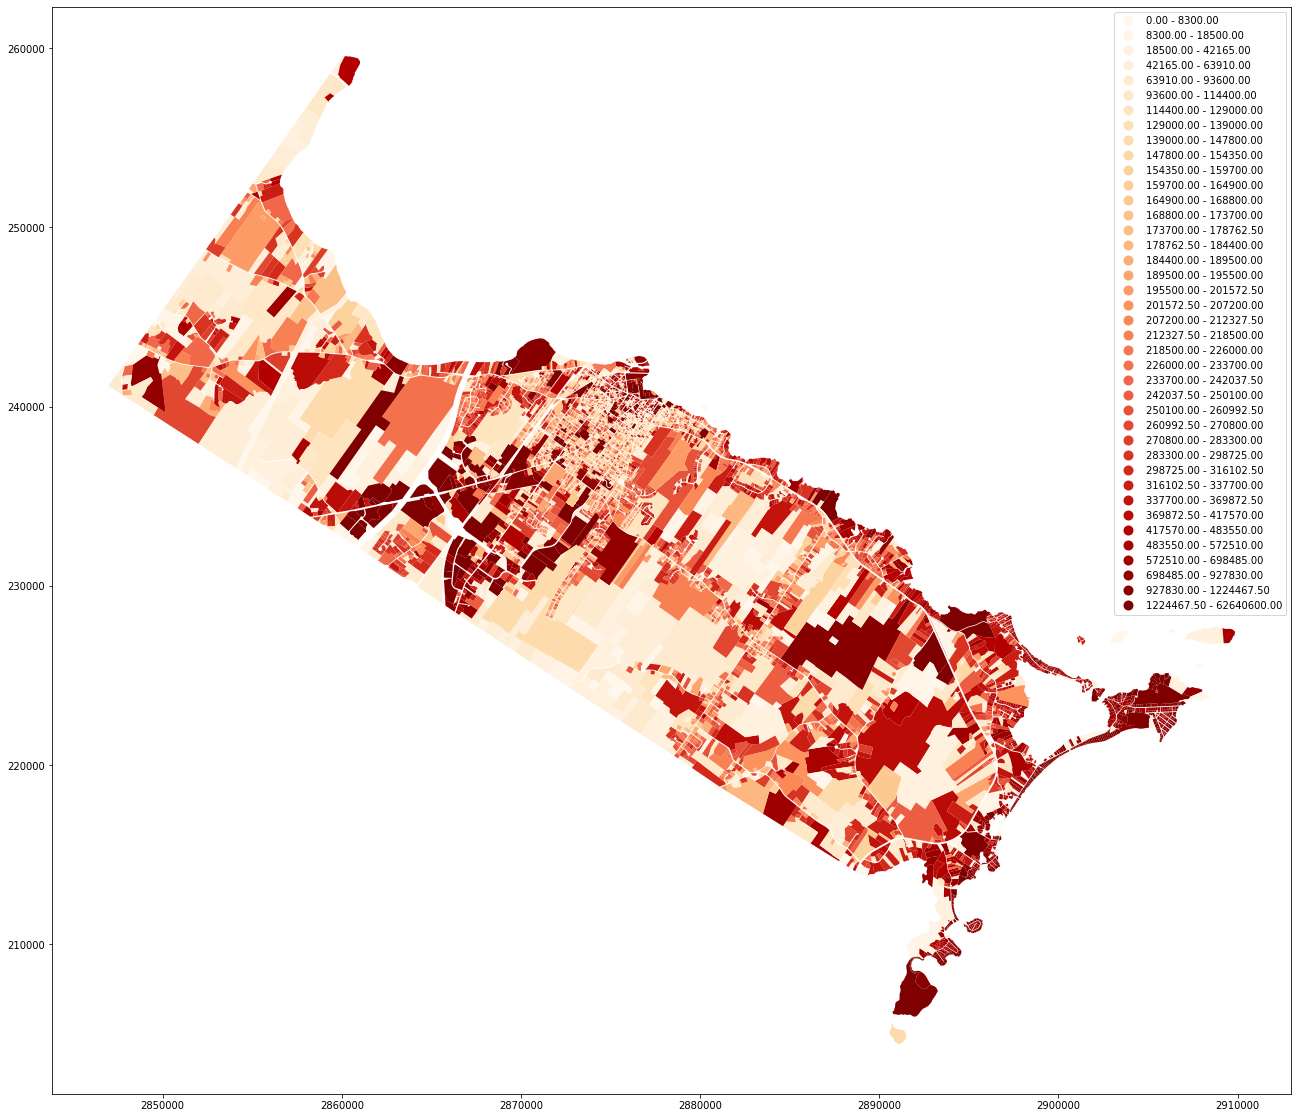

In [30]:
biddeford_parcels.plot(figsize=(110,20), column='Total_Val', scheme='QUANTILES', k=40, cmap='OrRd', legend=True)

This graph highlights the total value of each parcel of land in the city with the darker the color more value the city assigns it. If the city did not have limited amount of land it would be tempting to stop the heat map generation here and go into the graph creation to find the high value properties details.

Biddeford does have a limited amount of natural resources so this visualistion should be refined (think of it like a version of scaling used in assocative analysis) and show valuation data denominated in an uniform unit that's critical to this data set - square feet in this case.

#### Biddeford: Property Value by Square Foot per Parcel

In [31]:
# https://www.naahq.org/news-publications/us-apartment-sizes-shrinking
# According to the National Apartment Association 504 sq feet is now the average size of a studio
# This is down from 614 in mid-2000's so going to use the 504 as bare mininum of Land Area 
# while filtering

min_land_area = 504

biddeford_parcels = biddeford_parcels[(biddeford_parcels['Land_Area'] > min_land_area)]
biddeford_parcels['Value_SQ_Foot'] = biddeford_parcels['Total_Val'] / biddeford_parcels['Land_Area']
biddeford_parcels.sort_values('Value_SQ_Foot').tail(5)

,Map,Lot,SubLot,Polytype,LinkID,Ward,SenateDist,HouseDist,MeSPC_Loc,Updated,...,Land_Area,Build_Styl,Bath_Cnt,Exempt_Val,Bed_Cnt,Tax_Total_,LU_CODE,LU_DESC,geometry,Value_SQ_Foot
6032,59,25,0,parcel,59-25,1,33,9,0,None,...,1307.0,Condominium,1,0.0,2,315500.0,1020,CONDO MDL-05,"POLYGON ((2903143.495 223573.782, 2903002.193 ...",241.392502
6315,62,4,1,parcel,62-4-1,1,33,9,0,None,...,3920.0,Modern/Contemp,2.5,0.0,3,1138900.0,1012,OCN FT MDL-01,"POLYGON ((2900825.239 220875.849, 2900783.402 ...",290.535714
6501,64,49,0,parcel,64-49,1,33,9,0,2008-02-12,...,1742.0,Condominium,1.5,0.0,3,547500.0,1020,CONDO MDL-05,"POLYGON ((2897335.060 217365.365, 2897289.714 ...",314.293915
6502,64,49,0,parcel,64-49,1,33,9,0,2008-02-12,...,1742.0,Condominium,1,20000.0,3,531400.0,1020,CONDO MDL-05,"POLYGON ((2897335.060 217365.365, 2897289.714 ...",316.532721
4638,40,55,1,parcel,40-55-1,5,33,12,0,None,...,2178.0,Vacant Land,None,0.0,None,1064100.0,4420,IND LD UD MDL-00,"POLYGON ((2876679.682 242114.326, 2876677.243 ...",488.567493


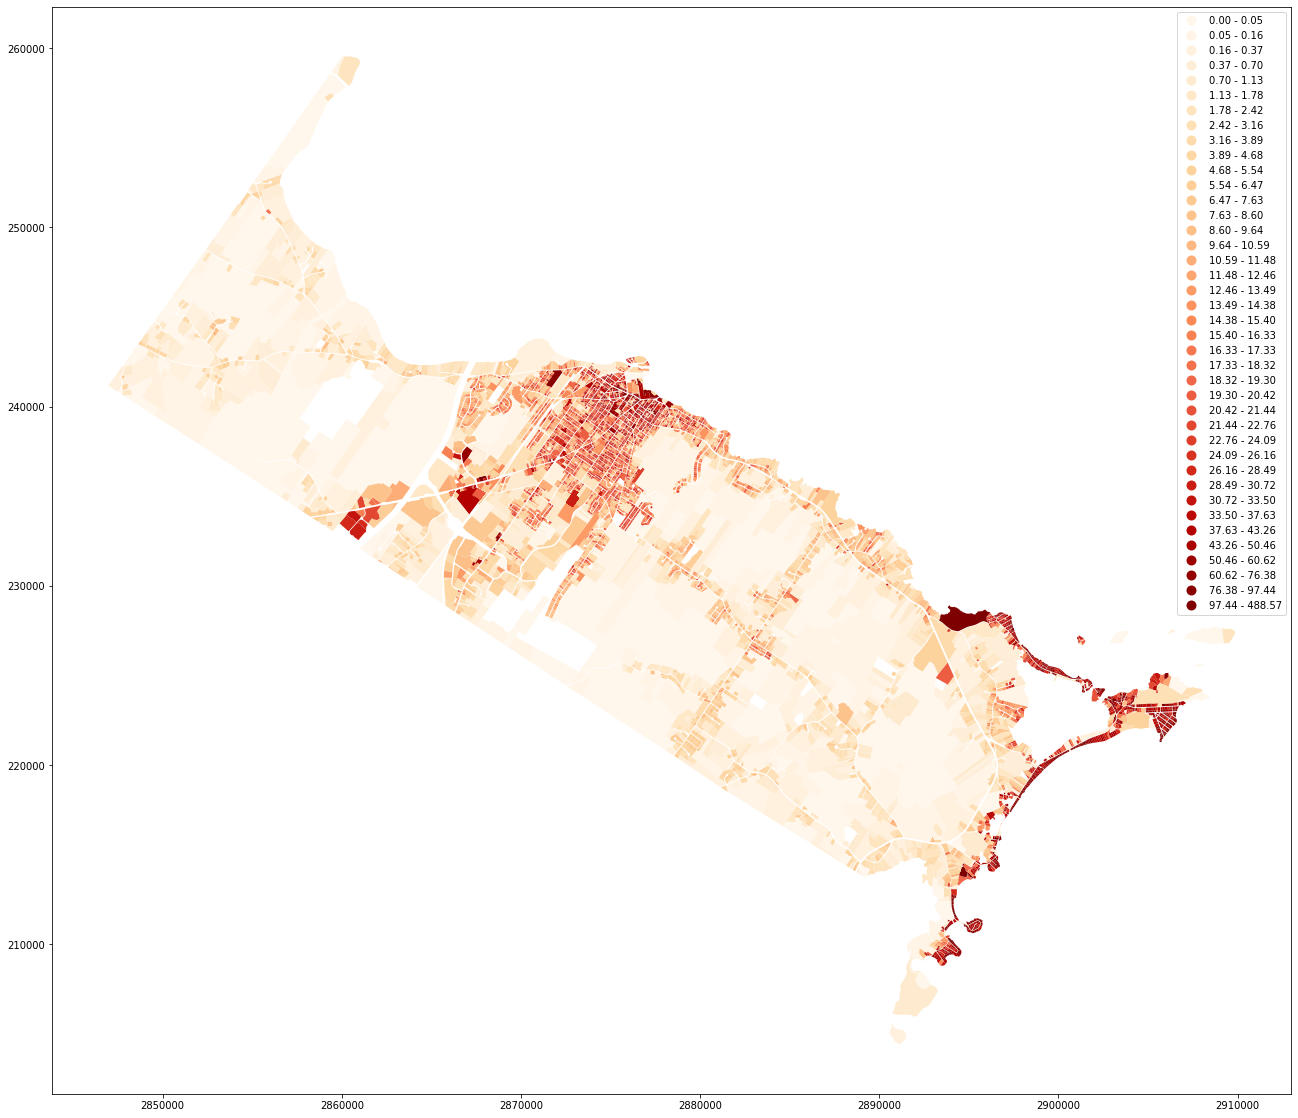

In [32]:
biddeford_parcels.plot(figsize=(200,20), column='Value_SQ_Foot', scheme='QUANTILES', k=40, cmap='OrRd', legend=True)


The other dark red along the river by the coordinates 2890000, 2300000 is UNE's main campus.
<img src="une-hills-beach-sq-ft.jpg" />


#### Clear Take Aways
- Roads make the immediate area more valuable per unit square foot of land. 
- Downtown, the summer communities, UNE's main campus and a couple buildings that are likely the middle and high school are very vaulable sections of town when viewed in sq foot terms.
- There are parcels in all the above mention areas where said current development pattern could expand into
- Having a waterview alone is not a very strong valuation attribute when viewed in value per sq foot terms


#### Locations for Further Analysis
What likely deserves more attention are:
- The effects of growing out the high performing by sq foot areas 

and

- The parcels that are high value in total but relatively low when priced per sq foot


**Downtown**
<img src="../images/down-town-total-parcel-value.jpg" alt="total valuation" />
<img src="../images/down-town-sq-value.jpg" alt="sq foot valuation" />

**Biddeford Pool**

<img src="../images/biddeford-pool-property-total-parcel-value.jpg" alt="total valuation" />

<img src="../images/biddeford-pool-property-value-sq-foot.jpg" alt="sq foot valuation" />

**Timber Point**

Total Valuation
<img src="../images/timber-granit-point-total-parcel-value.jpg" alt="total valuation" />

Square Foot Valution 
<img src="../images/timber-granit-point-value-sq-foot.jpg" alt="sq foot valuation" />


It is now time to dive into the actual numbers and locations to figure out the logisitics of actual proposals. This will be done by first creating filtered view of the `cleanedtax` datframe that includes these columns:

- Location
- Total_Val
- Tax_Total
- Land_Area

From there, more filtering will take place but it will be in regards to records instead of columns and it will be centered around `Land_Area` being greater than 20 sq feet. The 20 sq feet conditional is somewhat abritarty because the anlysis is looking to avoid parcel data where the `Land_Area` is somehow 0 or 1. 

Creating this view is important because a new `Sq_Foot_Val` column can be created (by dividing the `Total_Val` by `Land_Area` columns) and using this new variable the view can be sorted to find the actual properties and their corresponding data that are visibile on the heat maps.

In [33]:
# want to create a new column that tracks differnce between sq foot value and total property value

sq_foot_columns = ['Location', 'Total_Val', 'Tax_Total', 'Land_Area', 'Street',  'St_Num']
sq_foot_df = cleanedtax[sq_foot_columns]
sq_foot_df = sq_foot_df[sq_foot_df['Land_Area'] > min_land_area]
sq_foot_df['Sq_Foot_Val'] = sq_foot_df['Total_Val'] / sq_foot_df['Land_Area']


In [34]:
sorted_sq_foot_df = sq_foot_df.sort_values('Sq_Foot_Val')

sorted_sq_foot_df.tail(20)

,Location,Total_Val,Tax_Total,Land_Area,Street,St_Num,Sq_Foot_Val
4572,47 MAIN ST,162100,162100,871,MAIN ST,47,186.107922
6051,7 BAYVIEW AVE,324500,324500,1742,BAYVIEW AVE,7,186.280138
6031,9 LESTER B ORCUTT BLVD U-8,247800,247800,1307,LESTER B ORCUTT BLVD U-8,9,189.594491
6175,44 OCEAN AVE,1008300,1008300,5227,OCEAN AVE,44,192.902238
6169,23 SEVENTH ST,589500,589500,3049,SEVENTH ST,23,193.342079
5775,193 HILLS BEACH RD,1059500,1059500,5445,HILLS BEACH RD,193,194.582185
5785,3 SURF AVE,311700,311700,1600,SURF AVE,3,194.812500
5845,6 HANSONS LN,439200,439200,2240,HANSONS LN,6,196.071429
6311,50 MILE STRETCH RD,791200,791200,3920,MILE STRETCH RD,50,201.836735
3774,254 MAIN ST,1961400,1961400,9583,MAIN ST,254,204.674945


A good portion of these properties are likely going to be underwater in the near future and this study is looking to expand the tax base into the future so the next step is to filter for the properties that likely will still be around in the future. This research is depending on the domain knowledge on likely underwater status in creating the filtering list. This list consists of all properties on:

- FORTUNES ROCKS RD
- MILE STRETCH RD
- OCEAN AVE

*This list is no where near comprehensive

This filters the original top 20 list to these locations:

- GOOCH ST (OFF OF)
- 9 LESTER B ORCUTT BLVD U-9
- 145 MAIN ST
- 49 MAIN ST
- 75 SACO FALLS WAY
- 6 HANSONS LN
- 193 HILLS BEACH RD
- 23 SEVENTH ST
- 9 LESTER B ORCUTT BLVD U-8
- 7 BAYVIEW AVE
- 47 MAIN ST

The Hills Beach Rd. and the Seventh St. are likely going to be underwater in the pending future as well which leaves the list:

- GOOCH ST (OFF OF)
- 9 LESTER B ORCUTT BLVD U-9
- 145 MAIN ST
- 49 MAIN ST
- 75 SACO FALLS WAY
- 6 HANSONS LN
- 9 LESTER B ORCUTT BLVD U-8
- 7 BAYVIEW AVE
- 47 MAIN ST

Something to note is that Gooch Street has a handful of borderline abandoned buildings and it's very close to the condo/ apartment complex that is 75 Saco Falls Way.


##### Aerial View of Gooch and Saco Falls Way
<img src="ariel-saco-falls-gooch-st.jpg" />

#### Street View of Gooch Street
<img src="gooch-st-street-view.jpg" />


#### Street View of Saco Falls Way
<img src="75-saco-falls-way-street-view.jpg" />

Visibily these lots look quiet similiar with the main difference between them is one has been redeveloped to be offices and apartments while the other spot has not.

In [35]:
non_flood_valuable_sq_foot_properties = [
'GOOCH ST (OFF OF)',
# '9 LESTER B ORCUTT BLVD U-9',
#'145 MAIN ST',
#'49 MAIN ST',
'75 SACO FALLS WAY',
# '6 HANSONS LN',
# '9 LESTER B ORCUTT BLVD U-8',
# '7 BAYVIEW AVE',
# '47 MAIN ST'
]

non_flood_valuable_sq_foot_properties_data = cleanedtax[cleanedtax['Location'].isin(non_flood_valuable_sq_foot_properties)]
non_flood_valuable_sq_foot_properties_data.transpose()

,4639,4638,6954
Map,40,40,71
Lot,55,55,9
SubLot,2,1,2
Polytype,parcel,parcel,parcel
LinkID,40-55-2,40-55-1,71-9-2
Hist_Dist,0,0,1
Pine_Tr_Zn,0,0,1
Lot_Sub,55-2,55-1,9-2
FD,12,12,12
X10D_ID,1040055002,1040055001,1071009002


In [36]:
gooch_st_becomes_saco_falls = (7037400 * 2) - 1041000

gooch_st_improvements_10_years_percent = (gooch_st_becomes_saco_falls / value_increase_10_years) * 100
gooch_st_improvements_30_years_percent = (gooch_st_becomes_saco_falls / value_increase_30_years) * 100

print(gooch_st_improvements_30_years_percent, gooch_st_improvements_10_years_percent)

19.64274760625015 15.87162415670198


Doing a rough calculation and assuming that cloning the build value pf 75 Saco Falls is a likely possibility for the two Gooch street populations the new value would cover ~ `20%` and `16%` for the `30 year` and `10 year` benchmarks.


These improvements alone will not suffice. Main Street improvements and the Lester B. Orcutt BLVD parcel(s) look promising.


##### Lester B. Orcutt BLVD

<img src="9-lb-orcutt-blvd-street-view.jpg" />

In [37]:
non_flood_valuable_sq_foot_properties = [
# 'GOOCH ST (OFF OF)',
 '9 LESTER B ORCUTT BLVD U-9',
#'145 MAIN ST',
#'49 MAIN ST',
# '75 SACO FALLS WAY',
# '6 HANSONS LN',
 '9 LESTER B ORCUTT BLVD U-8',
# '7 BAYVIEW AVE',
# '47 MAIN ST'
]

non_flood_valuable_sq_foot_properties_data = cleanedtax[cleanedtax['Location'].isin(non_flood_valuable_sq_foot_properties)]
non_flood_valuable_sq_foot_properties_data.transpose()

,6031,6032
Map,59,59
Lot,25,25
SubLot,0,0
Polytype,parcel,parcel
LinkID,59-25,59-25
Hist_Dist,0,0
Pine_Tr_Zn,0,0
Lot_Sub,25,25
FD,2,2
X10D_ID,1059025000,1059025000


Quickly looking at the build to land values and the total values these properties on their own are not going to make noticble dents to reaching the garage value add goals.

This analysis probably should also look at: 
- land value as a percent of of total value
- build value per sq foot

This is so time is not spent any further looking at properties where adding or modifying the development on said land would produce negible effects on reaching the garage valuation hurdle.


In [38]:
cleanedtax['Sq_Foot_Val'] = cleanedtax['Total_Val'] / cleanedtax['Land_Area']
cleanedtax['Build_SQ_FT_Val'] = cleanedtax['Build_Val'] / cleanedtax['Build_SF']
cleanedtax['Land_Val_Per'] = cleanedtax['Land_Val'] / cleanedtax['Total_Val']

#### Main St. Parcels 

**47 and 49 Main St.**

Notice the left side is an empty mill building while across the street is some of the most productive real estate in the city. 

<img src="main-street-street-view.jpg" />



**145 Main St.***

Notice that the style is similar but renovated, one-two stories taller and next to a small park.

<img src="145-main-st-street-view.jpg" />

In [39]:
non_flood_valuable_sq_foot_properties = [
# 'GOOCH ST (OFF OF)',
# '9 LESTER B ORCUTT BLVD U-9',
'145 MAIN ST',
'49 MAIN ST',
# '75 SACO FALLS WAY',
# '6 HANSONS LN',
# '9 LESTER B ORCUTT BLVD U-8',
# '7 BAYVIEW AVE',
 '47 MAIN ST'
]

non_flood_valuable_sq_foot_properties_data = cleanedtax[cleanedtax['Location'].isin(non_flood_valuable_sq_foot_properties)]
non_flood_valuable_sq_foot_properties_data.transpose()

,4572,4573,4051
Map,39,39,38
Lot,74,75,370
SubLot,0,0,0
Polytype,parcel,parcel,parcel
LinkID,39-74,39-75,38-370
Hist_Dist,2,2,2
Pine_Tr_Zn,0,0,0
Lot_Sub,74,75,370
FD,12,12,12
X10D_ID,1039074000,1039075000,1038370000


In [40]:
main_street = cleanedtax[(cleanedtax['Street'] == 'MAIN ST') & ((cleanedtax['Location'] != 'MAIN ST'))]
vacant_lots_main_street = cleanedtax[(cleanedtax['Location'] == 'MAIN ST')]
main_street = main_street.sort_values('St_Num')
main_street.transpose()

,6895,6897,4677,6893,4714,4715,4716,4572,4573,4574,...,3484,3483,3482,3481,3509,2539,2528,2562,2577,2519
Map,71,71,41,71,41,41,41,39,39,39,...,36,36,36,36,36,32,32,32,32,32
Lot,11,12,1,10,136,137,138,74,75,76,...,13,12,11,10,8,3,2,5,6,1
SubLot,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
Polytype,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,...,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel
LinkID,71-11,71-12,41-1,71-10-1,41-136,41-137,41-138,39-74,39-75,39-76,...,36-13,36-12,36-11,36-10,36-8,32-3,32-2,32-5,32-6,32-1-1
Hist_Dist,1,1,0,1,2,2,2,2,2,2,...,0,0,0,0,0,0,0,0,0,0
Pine_Tr_Zn,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lot_Sub,11,12,1,10-1,136,137,138,74,75,76,...,13,12,11,10,8,3,2,5,6,1-1
FD,12,12,9,12,9,12,12,12,12,12,...,14,14,14,14,14,14,14,14,14,14
X10D_ID,1071011000,1071012000,1041001000,1071010001,1041136000,1041137000,1041138000,1039074000,1039075000,1039076000,...,1036013000,1036012000,1036011000,1036010000,1036008000,1032003000,1032002000,1032005000,1032006000,1032001001


Note the difference between the two parts of 2 Main Street in square foot valuations

In [41]:
main_street = main_street.replace([np.inf, -np.inf], np.nan)
#main_street = main_street.drop(infinite_build_sq_values, inplace=True)
main_street.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Map,130.0,3.842308e+01,5.990775e+00,3.200000e+01,3.700000e+01,3.800000e+01,3.800000e+01,7.100000e+01
Lot,130.0,1.017308e+02,1.148620e+02,1.000000e+00,1.525000e+01,4.650000e+01,1.377500e+02,3.870000e+02
SubLot,130.0,9.230769e-02,3.161335e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
Hist_Dist,130.0,7.692308e-01,9.607689e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,2.000000e+00
Pine_Tr_Zn,130.0,2.307692e-02,1.507287e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
X10D_ID,130.0,1.038525e+09,5.984506e+06,1.032001e+09,1.037032e+09,1.038016e+09,1.038141e+09,1.071012e+09
OBJECTID_1,130.0,4.689277e+03,5.722596e+02,3.515000e+03,4.423250e+03,4.604500e+03,4.732750e+03,7.247000e+03
Vision_PID,130.0,6.774708e+03,1.752966e+04,2.943000e+03,3.837250e+03,4.042500e+03,4.146750e+03,1.208460e+05
F10D_ID,130.0,1.038525e+09,5.984506e+06,1.032001e+09,1.037032e+09,1.038016e+09,1.038141e+09,1.071012e+09
St_Num,130.0,3.234923e+02,1.518856e+02,2.000000e+00,2.247500e+02,3.530000e+02,4.427500e+02,6.300000e+02


Note:
- Sq_Foot_Val: `7.166755e+02 ($71.66)`
- Build_SQ_FT_Val: `5.066459e+01 ($50.66)`


##### Value Generation Ideas:

- Wonder how much new value would be added if the second part of 2 Main Street's building was valued at the same rate of the first part on a sq foot basis?
- What does 6 Main Street look like with build sq valution at the mean instead of the low end?

#### 2 Main Street Build Improvements

In [42]:
# new value of part B of 2 Main St if build value becomes comparable to A 
# by multplying it by Build_SQ_FT_Val of A
two_main_st_B_potenial_value_add = (156.392 * 12366) - 88900
print(two_main_st_B_potenial_value_add)

1845043.4719999998


#### 6 Main St Build Improvements

In [43]:
six_main_st_build_improv = (50.66 * 25200) - 159700
print(six_main_st_build_improv)

1116932.0


In [44]:
six_main_st_build_improv_high_end = (156.392 * 25200) - 159700
print(six_main_st_build_improv_high_end)

3781378.4


These piecemeal improvements to the lower end building stock on the street that houses some of the most productive parcels of property in the city do not make much of an impact on reaching either of the garage valuation targets which is starting to make the idea that of developing the exisiting lower end building stock to a similar level of its current most productive as viable solutions look very questionable.

It is time to go larger in scale.

#### All of Main Street

What does all of Main Street look like with building sq/foot valuations like its max?

In [45]:
main_street.sum().transpose()

Map                                                             4995
Lot                                                            13225
SubLot                                                            12
Polytype           parcelparcelparcelparcelparcelparcelparcelparc...
LinkID             71-1171-1241-171-10-141-13641-13741-13839-7439...
Hist_Dist                                                        100
Pine_Tr_Zn                                                         3
Lot_Sub            1112110-11361371387475767778384382381385380379...
FD                 1212912912121212121212121212121212121212121212...
X10D_ID                                                 135008225012
OBJECTID_1                                                    609606
Vision_PID                                                    880712
GISID              71-1171-1241-171-10-141-13641-13741-13839-7439...
F10D_ID                                                 135008225017
St_Num                            

In [46]:
# Max Build_SQ_FT_Val: 1.563925e+02

all_main_st_max_improv = (872527 * 156.39) - 52094800
print(all_main_st_max_improv)

84359697.53


In [47]:
#47 Main Street build sq foot value: 62.833
all_main_st_middle_improv = (872527 * 62.833) - 52094800
print(all_main_st_middle_improv)

2728688.9909999967


## Conclusions


This analysis has not looked at other municipalities and what are normal sq foot valuations in Maine or in the US but to achieve similar valuation increases as the proposed garage project means multiple large for Biddeford development projects (8-12 Saco Falls Way redevelopment projects) or making already relatively very productive streets much more productive (i.e. making the max building value per square foot the average).

In [48]:
# looking for max build sq foot
cleanedtax = cleanedtax.replace([np.inf, -np.inf], np.nan)
cleanedtax.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Map,7989.0,3.594680e+01,2.319775e+01,1.000000e+00,2.000000e+01,3.400000e+01,5.000000e+01,8.800000e+01
Lot,7989.0,7.115309e+01,8.380606e+01,1.000000e+00,1.700000e+01,3.900000e+01,8.800000e+01,4.760000e+02
SubLot,7989.0,8.530479e-01,2.479346e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.100000e+01
Hist_Dist,7989.0,2.428339e-02,2.132589e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00
Pine_Tr_Zn,7989.0,1.940168e-02,2.140510e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
X10D_ID,7989.0,1.036018e+09,2.319437e+07,1.001001e+09,1.020048e+09,1.034255e+09,1.050023e+09,1.088055e+09
OBJECTID_1,7989.0,4.030244e+03,2.320302e+03,1.000000e+00,2.024000e+03,4.035000e+03,6.036000e+03,8.043000e+03
Vision_PID,7989.0,1.588417e+04,3.414593e+04,8.000000e+00,2.155000e+03,4.190000e+03,6.257000e+03,1.221280e+05
F10D_ID,7989.0,1.035260e+09,3.664681e+07,0.000000e+00,1.020047e+09,1.034255e+09,1.050023e+09,1.088055e+09
St_Num,7989.0,9.543122e+01,1.490730e+02,0.000000e+00,8.000000e+00,2.500000e+01,1.100000e+02,9.240000e+02


In [49]:
cleanedtax.sort_values('Build_SQ_FT_Val').tail(100).transpose()

,5430,765,3978,564,7088,1190,5123,3773,5101,3788,...,6667,4638,756,5122,6900,1340,878,5507,4677,725
Map,49,2,38,18,75,2,4,38,4,38,...,67,40,20,4,71,2,2,5,41,20
Lot,9,10,296,29,6,42,40,124,35,136,...,30,55,53,4,2,56,19,14,1,26
SubLot,0,1,0,2,0,4,0,1,1,0,...,0,1,0,0,0,0,0,0,0,1
Polytype,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,...,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel,parcel
LinkID,49-9,2-10-1,38-296,18-29-2,75-6,2-42-4,4-40,38-124-1,4-35-1,38-136,...,67-30,40-55-1,20-53,4-4,71-2,2-56,2-19,5-14,41-1,20-26-1
Hist_Dist,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
Pine_Tr_Zn,0,0,0,0,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Lot_Sub,9,10-1,296,29-2,6,42-4,40,124-1,35-1,136,...,30,55-1,53,4,2,56,19,14,1,26-1
FD,4,18B,13,17,1,18,4,12,4,12,...,1,12,18,4,12,18,5,4,9,18
X10D_ID,1049009000,1002010001,1038296000,1018029002,1075006000,1002042004,1004040000,1038124001,1004035001,1038136000,...,1067030000,1040055001,1020053000,1004004000,1071002000,1002056000,1002019000,1005014000,1041001000,1020026001
